In [3]:
#Importing the necessary packages
import gym 
import tensorflow as tf 
import numpy as np 
import random 
import matplotlib.pyplot as plt

In [ ]:
env = gym.make('Pong-v0')
print(env.action_space)
print(env.observation_space)

In [5]:
class ExperienceBuffer: 
    
    def __init__(self): 
        self.buffer = []
        self.buffer_capacity = 1000000
        self.current_length = 0
    def write(self, obs): 
        if self.current_length == self.buffer_capacity: 
            self.buffer.pop()
            self.current_length -= 1
        self.buffer.append(obs)
        self.current_length +=1
    def sample_buffer(self, batch_to_sample): 
        return random.sample(self.buffer, min(batch_to_sample, self.current_length))
    def get_capacity(self): 
        return self.current_length

In [6]:
class Network:
    
    def __init__(self, session , n_out):
        self.session = session
        self.n_out = n_out
        # data placeholders
        self.x = tf.placeholder(tf.float32, [None, 4, 84, 84])
        self.tp = tf.transpose(self.x, perm = [0,2,3,1])
        self.y = tf.placeholder(tf.float32, [None, n_out], name='y')
        self.conv_1 = tf.layers.conv2d(self.tp, filters = 32, kernel_size = 8, strides = 4, activation = tf.nn.relu)
        self.conv_2 = tf.layers.conv2d(self.conv_1, filters = 64, kernel_size = 4, strides = 2, activation = tf.nn.relu)
        #self.max_pool_1 = tf.layers.MaxPooling2D(pool_size = 2, strides = 2)
        self.flat_layer = tf.layers.flatten(self.conv_2)
        self.bottleneck_layer = tf.layers.dense(self.flat_layer, 512)
        self.q = tf.layers.dense(self.bottleneck_layer, n_out)
        #COULD BE BUGGY!
        self.loss = tf.reduce_sum(tf.square(self.y - self.q))
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
    def compute(self, input_frames):
        # evaluate the network and return the action values [q(s,a=0),q(s,a=1)]
        return self.session.run(self.q, feed_dict={self.x:input_frames})
    def train(self, x_batch, y_batch): 
            _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})

In [7]:
class ReshapeImage: 
    #Source for data processing: this is also the same as the openAI baseline https://github.com/fg91/Deep-Q-Learning/blob/master/DQN.ipynb
    def __init__(self, target_height = 84, target_width = 84):
        self.target_height = target_height
        self.target_width = target_width
        self.input_rgb_image = tf.placeholder(shape = [4,210,160,3], dtype = tf.uint8)
        self.grayscale_img = tf.image.rgb_to_grayscale(self.input_rgb_image)
        self.bounded_img = tf.image.crop_to_bounding_box(self.grayscale_img, 34, 0, 160, 160)
        self.final_processed = tf.image.resize_images(self.bounded_img, 
                                                [self.target_height, self.target_width], 
                                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    def return_processed_img(self, session, input_img):
        return session.run(self.final_processed, feed_dict = {self.input_rgb_image: input_img})

In [29]:
class Agent: 
    
    def __init__(self, session, policy): 
        #Want a pretty high gamma at first
        self.gamma = 0.99
        #Want pure exploration at first 
        self.epsilon = 1.0
        #want massive adjustments to Q function at first
        self.alpha = 1.0
        #There are six possible outputs
        self.n_out = 6
        #Tune this
        self.batch_size = 32
        self.total_reward = 0
        self.policy = policy
        self.session = session
        self.experience_buffer = ExperienceBuffer()
        self.q = Network(session, self.n_out)
        self.image_reshaper = ReshapeImage()
    def get_action(self, observation): 
        if self.policy == 'DQN':
            if np.random.randn() > self.epsilon: 
                #reshaped_obs = self.image_reshaper.return_processed_img(self.session, observation)
                #need to fix this to feed in 4 stacked frames
               # pos = np.argmax(self.q.compute(reshaped_obs), axis = 1)
                #return pos[0];
                #print('use dqn')
                processed_obv = self.image_reshaper.return_processed_img(self.session, observation)
                processed_obv = np.squeeze(processed_obv)
                padded_processed = np.expand_dims(processed_obv, axis = 0)
                action_values = self.q.compute(padded_processed)
                max_action = np.argmax(action_values, axis = 1)
                return max_action[0]
            else: 
                #print('chose randomly')
                return random.randint(0,5)
        if self.policy == "dqn_test": 
                #print('use blt in q function')
                processed_obv = self.image_reshaper.return_processed_img(self.session, observation)
                processed_obv = np.squeeze(processed_obv)
                padded_processed = np.expand_dims(processed_obv, axis = 0)
                action_values = self.q.compute(padded_processed)
                max_action = np.argmax(action_values, axis = 1)
                return max_action[0]
    def adjust_epsilon(self, episode_number):
        self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-.003*episode_number)
    def get_epsilon(self):
        return self.epsilon
    def gather_buffer_exp(self, last_obs, action, reward, obs): 
        processed_obv = self.image_reshaper.return_processed_img(self.session, obs)
        processed_obv = np.squeeze(processed_obv)
        processed_last_obv = self.image_reshaper.return_processed_img(self.session, last_obs)
        processed_last_obv = np.squeeze(processed_last_obv)
        self.experience_buffer.write((processed_last_obv, action, reward, processed_obv))
    def gather_reward(self, reward): 
        self.total_reward += reward
    def get_total_reward(self): 
        return self.total_reward
    def set_reward(self, new_reward): 
        self.total_reward = new_reward
    def return_buffer_size(self): 
        return self.experience_buffer.get_capacity()
    def update_q(self): 
        #PRETTY SURE THIS IS BUSTED BUT FIX LATER!
        self.sars_buffer = self.experience_buffer.sample_buffer(self.batch_size)
        the_x_batch = np.zeros(shape = (np.shape(self.sars_buffer)[0], 4,84,84))
        the_y_batch = np.zeros(shape = (np.shape(self.sars_buffer)[0], self.n_out))
        last_stateq = np.zeros(shape = (np.shape(self.sars_buffer)[0], self.n_out))
        next_q = np.zeros(shape = (np.shape(self.sars_buffer)[0], self.n_out))
        for i in range(np.shape(self.sars_buffer)[0]):
            padded_processed = np.expand_dims(self.sars_buffer[i][0], axis = 0)
            p2 = np.expand_dims(self.sars_buffer[i][3], axis = 0)
            last_stateq[i, :] = self.q.compute(padded_processed)
            next_q[i,:] = self.q.compute(p2)
        for i in range(np.shape(self.sars_buffer)[0]): 
            the_x_batch[i, :] = self.sars_buffer[i][0]
            for j in range(6): 
                if j == self.sars_buffer[i][1]:
                     #action we need to update
                    the_y_batch[i, j] = self.sars_buffer[i][2] + self.gamma * np.max(next_q[i])
                else: 
                     #use the previous q value
                    the_y_batch[i,j] = last_stateq[i,j]
                    
        self.q.train(the_x_batch, the_y_batch)

starting episodes
epsilon1.0
(4, 210, 160, 3)
Episode 0 finished after 1314 timesteps with total reward -20.0
current buffer size is 1313


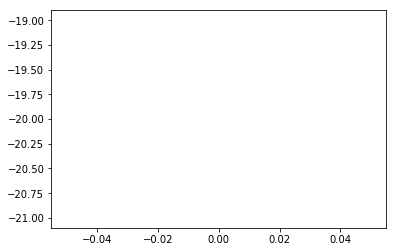

starting episodes
epsilon1.0
(4, 210, 160, 3)
Episode 1 finished after 1205 timesteps with total reward -20.0
current buffer size is 2517
starting episodes
epsilon0.9970344505483393
(4, 210, 160, 3)
Episode 2 finished after 1020 timesteps with total reward -21.0
current buffer size is 3536
starting episodes
epsilon0.9940777844133959
(4, 210, 160, 3)
Episode 3 finished after 1232 timesteps with total reward -20.0
current buffer size is 4767
starting episodes
epsilon0.9911299749851548
(4, 210, 160, 3)
Episode 4 finished after 1443 timesteps with total reward -19.0
current buffer size is 6209
starting episodes
epsilon0.9881909957333113
(4, 210, 160, 3)
Episode 5 finished after 1260 timesteps with total reward -20.0
current buffer size is 7468
starting episodes
epsilon0.985260820207032
(4, 210, 160, 3)
Episode 6 finished after 1226 timesteps with total reward -21.0
current buffer size is 8693
starting episodes
epsilon0.9823394220347178
(4, 210, 160, 3)
Episode 7 finished after 1148 timeste

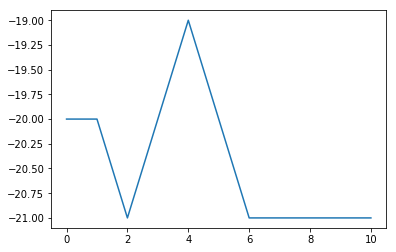

starting episodes
epsilon0.970741078213023
(4, 210, 160, 3)
Episode 11 finished after 1213 timesteps with total reward -20.0
current buffer size is 14320
starting episodes
epsilon0.9678631739931417
(4, 210, 160, 3)
Episode 12 finished after 1462 timesteps with total reward -18.0
current buffer size is 15781
starting episodes
epsilon0.9649938905482919
(4, 210, 160, 3)
Episode 13 finished after 1279 timesteps with total reward -20.0
current buffer size is 17059
starting episodes
epsilon0.962133202054903
(4, 210, 160, 3)
Episode 14 finished after 1210 timesteps with total reward -20.0
current buffer size is 18268
starting episodes
epsilon0.9592810827667597
(4, 210, 160, 3)
Episode 15 finished after 1062 timesteps with total reward -21.0
current buffer size is 19329
starting episodes
epsilon0.9564375070147689
(4, 210, 160, 3)
Episode 16 finished after 1262 timesteps with total reward -21.0
current buffer size is 20590
starting episodes
epsilon0.9536024492067297
(4, 210, 160, 3)
Episode 17 

In [ ]:
#Code to test the actual env:


with tf.Graph().as_default():
    with tf.Session() as session: 
        agent = Agent(session, 'DQN')
        session.run(tf.global_variables_initializer())
        episode_rewards = []
        newshape = ReshapeImage()
        for i_episode in range(800):
            print('starting episodes')
            the_ep = agent.get_epsilon()
            print("epsilon{}".format(the_ep))
            observation = env.reset()
            observation = np.stack([observation,observation,observation,observation], axis = 0)
            print(np.shape(observation))
            agent.set_reward(0)
            for t in range(4000):
                flag = True
                #env.render()
                action = agent.get_action(observation)
                new_observation, reward, done, info = env.step(action)
                new_matrix = np.zeros((4,210,160,3))
                new_matrix[0,:,:,:] = observation[1,:,:,:]
                new_matrix[1,:,:,:] = observation[2,:,:,:]
                new_matrix[2,:,:,:] = observation[3,:,:,:]
                new_matrix[3,:,:,:] = new_observation
                new_observation = new_matrix
                #checkout how the image looks
                #new_img = newshape.return_processed_img(session,new_observation[:,:,:,:])
                #print(np.shape(new_img))
                #new_img = np.squeeze(new_img)
                #print(np.shape(new_img))
                #plt.imshow(new_img[3,:,:])
                #plt.show()
                #print(np.shape(new_observation))
                
                if done: 
                    new_observation = None
                    flag = False
                #print("the reward at stage {} was {} and the action was {}, during episode {}".format(t, reward, action,i_episode))
                agent.gather_reward(reward)
                if flag: 
                    agent.gather_buffer_exp(observation, action, reward, new_observation)
                agent.update_q()
                observation = new_observation
                if done:
                    the_ep_reward = agent.get_total_reward()
                    print("Episode {} finished after {} timesteps with total reward {}".format(i_episode, t+1, agent.get_total_reward()))
                    episode_rewards.append(the_ep_reward)
                    print("current buffer size is {}".format(agent.return_buffer_size()))
                    break
            agent.adjust_epsilon(i_episode)
            if(i_episode % 10 == 0):
                plt.plot(episode_rewards)
                plt.show()
        #Testing learned function
        episode_rewards = []
        for (i_ep) in range(51):
            agent.adjust_epsilon(0)
            agent.set_reward(0)
            observation = env.reset()
            observation = np.stack([observation,observation,observation,observation], axis = 0)
            for t in range(4000):
                flag = True
                #env.render()
                action = agent.get_action(observation)
                new_observation, reward, done, info = env.step(action)
                new_matrix = np.zeros((4,210,160,3))
                new_matrix[0,:,:,:] = observation[1,:,:,:]
                new_matrix[1,:,:,:] = observation[2,:,:,:]
                new_matrix[2,:,:,:] = observation[3,:,:,:]
                new_matrix[3,:,:,:] = new_observation
                new_observation = new_matrix
                #checkout how the image looks
                #new_img = newshape.return_processed_img(session,new_observation[:,:,:,:])
                #print(np.shape(new_img))
                #new_img = np.squeeze(new_img)
                #print(np.shape(new_img))
                #plt.imshow(new_img[3,:,:])
                #plt.show()
                #print(np.shape(new_observation))
                
                if done: 
                    new_observation = None
                    flag = False
                #print("the reward at stage {} was {} and the action was {}, during episode {}".format(t, reward, action,i_episode))
                agent.gather_reward(reward)
                #if flag: 
                #    agent.gather_buffer_exp(observation, action, reward, new_observation)
                #agent.update_q()
                observation = new_observation
                if done:
                    the_ep_reward = agent.get_total_reward()
                    print("Episode {} finished after {} timesteps with total reward {}".format(i_ep, t+1, agent.get_total_reward()))
                    episode_rewards.append(the_ep_reward)
                    print("current buffer size is {}".format(agent.return_buffer_size()))
                    break
        if(i_ep % 10 == 0):
                plt.plot(episode_rewards)
                plt.show()
#plt.plot(episode_rewards)
#plt.show()

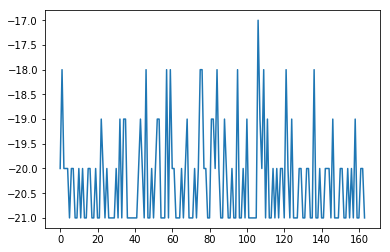

In [12]:
plt.plot(episode_rewards)
plt.show()

In [7]:
#To test the image reshaper
with tf.Graph().as_default():
    with tf.Session() as sess: 
        reshaper = ReshapeImage()
        x = np.random.rand(4,210,160,3)
        fin_img = reshaper.return_processed_img(sess, x)
        print(fin_img.shape)

(4, 84, 84, 1)


In [14]:
#to test network 
with tf.Graph().as_default(): 
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        x = np.random.rand(55,4,84,84)
        the_net = Network(session, 6)
        session.run(tf.global_variables_initializer())
        q_func = the_net.compute(x)
        print(q_func.shape)
       # y =np.array([ x[:,:,:,2]+x[:,:, :, 3]**2, x[:,:,:, 1]+x[:,:, :, 0]**3, x[:,:,:,2]+x[:,:, :, 3]**2,  x[:,:,:,2]+x[:,:, :, 3]**2,  x[:,:,:,2]+x[:,:, :, 3]**2,  x[:,:,:,2]+x[:,:, :, 3]**2 ])
            
       # print('MSE at iteration 0 is {}'.format(((the_net.compute(x) - y)**2).mean()))
        
        # now train...
       # for i in range(10000):
       #     f.train(x,y)
        
       # print('MSE at iteration 10000 is {}'.format(((f.compute(x) - y)**2).mean()))

(55, 6)


In [159]:
lol = ExperienceBuffer()
for i in range(300): 
    x = np.random.rand(84,84,4)
    y = np.random.randn()
    z = np.random.randn()
    w = np.random.rand(84,84,4)
    lol.write((x,y,z,w))
zed= lol.sample_buffer(32)
print(np.shape(zed))
print(np.shape(zed[0][0]))


(32, 4)
(84, 84, 4)


In [18]:
x = np.random.randn(4,84,84)
x = np.transpose(x, (1,2,0))
print(x.shape)

(84, 84, 4)
